Simulated Annealing
=======

# Theory
**Simulated Annealing (SA)** is a metaheuristic optimization technique to approximate the global optimum of a function.

## Definition
**Simulated Annealing (SA)** technique is inspired from the annealing process in metals, hence the name; to achieve the optimization task. To get some context, lets recall the annealing process in metals
 
>Annealing process in metals starts by heating off the metal at very high temperatures and then cool it down with some predefined cooling schedule. During this process, the movement of particles in the metal progressively shift from fast and random motion "at high energy state" to slow and stationary motion "at low energy state" to eventually converge to the lowest energy state.

By analogy, simulated annealing want to model such explorative behaver that allowed the metal to visit different particles configurations at high energy state and eventually converged to the optimal particles configuration at the lowest energy state. To do that in context of optimization problems; some key concepts are imported from the physical process:
- Temperature
- Cooling schedule
- Energy state

These parameters will control how the algorithm explore the search space and its tolerance to accept worse less optimal solutions during search for the sake of exploration.


### Algorithm
To elaborate more on how these imported components achieve the explorative behaver, lets illustrate the simulated annealing algorithm with this pusoducode.

> $\mathtt{T_0} \leftarrow$ initial temperature of cooling schedule\
> $\texttt{current solution} \leftarrow$ starting solution candidate
>
> `for` $\texttt{i} = \lbrace 0, \dots, \texttt{max iterations}\rbrace$ `do`
>> $\texttt{neighbor solution} \leftarrow$ sample new neighbor from $\texttt{current solution}$ neighborhood\
>> $\Delta \mathtt{cost} = \mathtt{cost}(\texttt{neighbor solution}) - \mathtt{cost}(\texttt{current solution})$
>> 
>> `if` $\mathtt{cost}(\texttt{neighbor solution})$ `is better than` $\mathtt{cost}(\texttt{current solution})$ `then accept`
>>> $\texttt{current solution} \leftarrow \texttt{neighbor solution}$
>>
>> `else if` $\mathtt{cost}(\texttt{neighbor solution})$ `is worse`, `then accept with probability` $E_i = e^{-\Delta \mathtt{cost} \,/\,\mathtt{T_i}}$
>>> $\texttt{current solution} \leftarrow \texttt{neighbor solution}$
>>
>> `else` none the above `then reject`
>>> stay at $\texttt{current solution}$
>>
>>  $\mathtt{T_i} \leftarrow$ cooling schedule($\texttt{i}$)
>>
> `end`

The part in the algorithm where the algorithm accept worse solutions with some probability is responsible in mimicking the explorative behaver. This probability is dependent on energy at current state "i.e. high energy means that you have more potential to explore different solutions, even it there are worse"
$$
\begin{equation}
E_i = e^{-\Delta \mathtt{cost} \,/\,\mathtt{T_i}}
\end{equation}$$

<div style="text-align:center"><img src="./Resources/Simulated Annealing.png" width="600"/></div>

The notion of function is generic where any problem that can be formulated in terms of solution candidate and solution cost can be addressed by this technique.



## Examples


# Implementation


## Imports

In [8]:
import matplotlib
import numpy as np
import pandas as pd
from typing import Callable
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [9]:
# cost function and neighbor sampling
cost_func = lambda x : 30*np.sin(x) + x**2                    # function to optimize
get_neighbor = lambda x : x + np.random.uniform(-5,5)         # sample neighbor from the neighborhood of x
x_0 = 2.5                                                     # starting value search

# cooling schedule
cooling_func = lambda t : 1000*np.exp(-0.7*t)                 # temperature decay function
cooling_window = [0,20]                                       # cooling function domain

## Algorithm


In [10]:
def SA(cost_func: Callable, sample_neighbor: Callable, x_0: float, cooling_schedule: tuple[Callable, list], maxiter: int = int(5e2), task: str = "minimization") -> tuple[float, list, int]:
    '''
    Simulated annealing algorithm to approximated the global optimum of a given cost function

    Args:
        cost_func: Cost function, in this case represented by 1D mathematical expression
        sample_neighbor : Function that randomly sample a neighbor from neighborhood around current x value
        x_0: Search starting value
        cooling_schedule: Cooling behavior, include cooling profile and window
        maxiter: Maximum number of iterations "i.e. sampling attempts". Defaults to int(1e3).
        task: Search task. choose between `"minimization"` or `"maximization"`. Defaults to "minimization".

    Returns:
        The optimal x value of the cost function, the number of accepted samples during search, and the search
        history record.
    '''

    
    # unpack arguments
    factor = -1 if task == "maximization" else 1 
    cooling_func, cooling_window = cooling_schedule

    # algorithm data
    T = cooling_func( np.linspace(*cooling_window, num=maxiter) )
    cost = [cost_func(x_0)]
    accepted_samples = 0
    x = [x_0]


    for i in range(maxiter-1):
        
        x_neighbor = sample_neighbor(x[-1])
        delta_cost = ( cost_func(x_neighbor) - cost_func(x[-1]) )*factor

        # accept if neighbor is better, or accept with energy-driven probability if worse
        if delta_cost <= 0 or np.exp(-delta_cost/T[i]) > np.random.uniform(0,1):
            x.append(x_neighbor)
            cost.append(cost_func(x_neighbor))
            accepted_samples+=1

        # reject bad neighbor "stay where you are"
        else:
            x.append(x[-1])
            cost.append(cost_func(x[-1]))


    x_optimal, history = x[-1], pd.DataFrame({"cost": cost, "x": x, "temperature": T})

    return x_optimal, accepted_samples, history

## Results Visualization & Basic Convergence Analysis


In [11]:
x_optimal, accepted_samples, history = SA(cost_func=cost_func,
                                          sample_neighbor=get_neighbor,
                                          x_0=x_0, 
                                          cooling_schedule=(cooling_func, cooling_window), 
                                          )

In [12]:
%%capture
fig, ax = plt.subplots(figsize=(6,6))

# fine domain and range limits
xx = np.linspace(history["x"].min()-4, history["x"].max()+4, num=100)
y_lim = [np.min(cost_func(xx))-0.2*np.ptp(cost_func(xx)), np.max(cost_func(xx))+0.2*np.ptp(cost_func(xx))]

# simulated annealing sampling animation 
## statics components
main_function,      = ax.plot(xx, cost_func(xx), "k")
sample_x_ticks,     = ax.plot([history["x"][0]], [y_lim[0]], "r|", clip_on=False, zorder=100)
sample_line,        = ax.plot([], [], "r--")
sample_point,       = ax.plot([], [], "ro")
temperature_count,  = ax.plot([], [], "k>", label="Temperature = "+"{:.2f}".format(history["temperature"][0]))

## decorations
ax.set(xlabel="x", ylabel="f(x)", ylim=y_lim, title="Simulated Annealing Sampling")
legend = ax.legend()
ax.grid(True)

def animate(frame: int) -> tuple:

    ## animated components
    sample_line.set_data([history["x"][frame], history["x"][frame]], [y_lim[0], cost_func(history["x"][frame])])
    sample_point.set_data([history["x"][frame]], [cost_func(history["x"][frame])])
    sample_x_ticks.set_data([history["x"][:frame]], [y_lim[0]])
    legend.get_texts()[0].set_text("Temperature = "+"{:.2f}".format(history["temperature"][frame]))

    return sample_line, sample_point, sample_x_ticks

ani = FuncAnimation(fig, animate, frames=len(history["x"]), blit=True, interval=30)

ani.save('./Resources/Simulated Annealing-Result.gif', writer=PillowWriter(fps=30))

<div style="text-align:center"><img src="./Resources/Simulated Annealing-Result.gif" width="500"/></div>

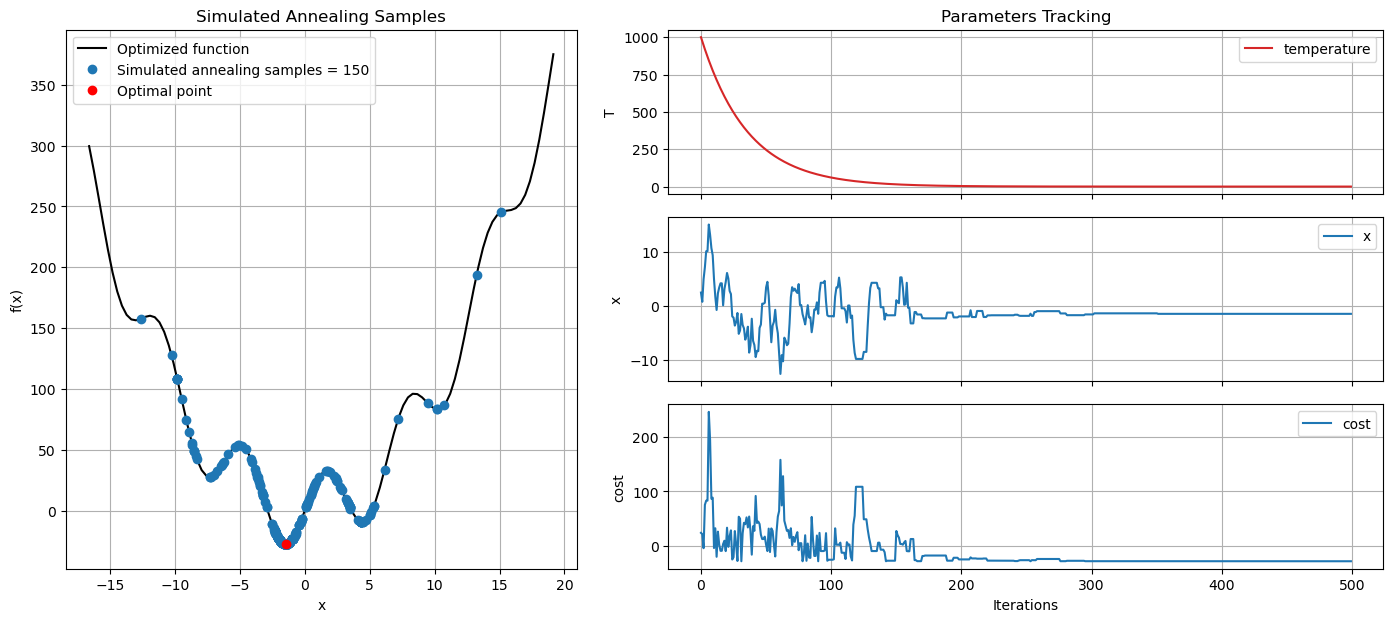

,Property,Value
0,optimal x,-1.451777
1,cost at optimal x,-27.68011
2,total search samples,500 samples
3,accepted samples,150 samples
4,rejected samples,350 samples


In [14]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
                              ['upper left',       'right'],
                              ['upper left', 'lower right']],
                             figsize=(17,7), gridspec_kw={'width_ratios': [1, 1.4]})


# simulated annealing sampling plot
ax['upper left'].plot(xx, cost_func(xx), "k", label="Optimized function")
ax['upper left'].plot(history["x"], cost_func(history["x"]), "o", label=f"Simulated annealing samples = {accepted_samples}")
ax['upper left'].plot(x_optimal, cost_func(x_optimal), "ro", label="Optimal point")
ax['upper left'].set(xlabel="x", ylabel="f(x)", title="Simulated Annealing Samples")
ax['upper left'].grid(True)
ax['upper left'].legend()

# temperature value tracking
ax['upper right'].plot(history["temperature"], "tab:red", label="temperature")
ax['upper right'].set(ylabel="T", title="Parameters Tracking")
ax['upper right'].xaxis.set_ticklabels([])
ax['upper right'].grid(True)
ax['upper right'].legend()

# x value tracking
ax['right'].plot(history["x"], label="x")
ax['right'].xaxis.set_ticklabels([])
ax['right'].set(ylabel="x")
ax['right'].grid(True)
ax['right'].legend()

# cost value tracking
ax['lower right'].plot(history["cost"], label="cost")
ax['lower right'].set(xlabel="Iterations", ylabel="cost")
ax['lower right'].grid(True)
ax['lower right'].legend()

# summary
summary = [
    ("optimal x", x_optimal),
    ("cost at optimal x", cost_func(x_optimal)),
    ("total search samples", f'{len(history["x"])} samples'),
    ("accepted samples", f'{accepted_samples} samples'),
    ("rejected samples", f'{len(history["x"]) - accepted_samples} samples')
    ]

df = pd.DataFrame(data=summary, columns=["Property", "Value"])

plt.subplots_adjust(wspace=0.15, hspace=0.14)
plt.show()
df